# Get eye points
### https://stackoverflow.com/questions/36956278/pupil-detection-in-opencv-python

In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math
import imutils

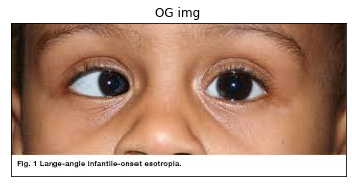

In [169]:
EYE_CLASSIFIER = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('OG img')
plt.show()

In [170]:
# helper functions
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)

def detect_eyes(img, cascade):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = cascade.detectMultiScale(gray_frame, 1.3, 5)  # detect eyes
    width = np.size(img, 1)  # get face frame width
    height = np.size(img, 0)  # get face frame height
    left_eye = None
    right_eye = None
    for (x, y, w, h) in eyes:
        if y > height / 2:
            pass
        eyecenter = x + w / 2  # get the eye center
        if eyecenter < width * 0.5:
            left_eye = img[y:y + h, x:x + w]
        else:
            right_eye = img[y:y + h, x:x + w]
    return left_eye, right_eye

def cut_eyebrows(img):
    height, width = img.shape[:2]
    eyebrow_h = int(height / 4)
    img = img[eyebrow_h:height, 0:width]  # cut eyebrows out (15 px)

    return img


def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    keypoints = detector.detect(img)
    print(keypoints)
    return keypoints

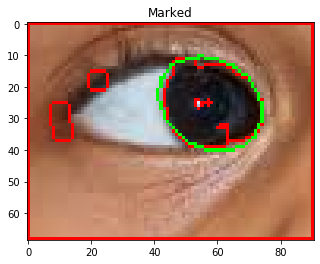

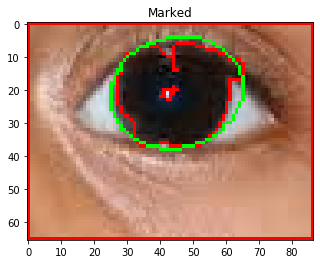

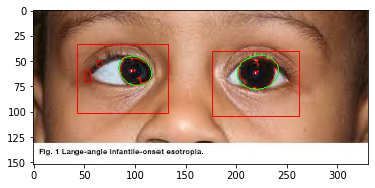

In [288]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
eyes = detect_eyes(img, EYE_CLASSIFIER)

for eye in eyes:
    if eye is not None:
        eye = cut_eyebrows(eye)
        gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 60, 255, 0) #CV_THRESH_BINARY

        c = cv2.erode(cv2.dilate(thresh, kernel,iterations=1),kernel,iterations=1)

        contours, hierarchy = cv2.findContours(c, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(eye, contours,-1,(255,0,0),1)

        for contour in contours:
        
            contour = cv2.convexHull(contour)
            area = cv2.contourArea(contour)
            if area < 250:
                continue
                
            circumference = cv2.arcLength(contour,True)
            circularity = circumference ** 2 / (4*math.pi*area)
            
            bb = cv2.boundingRect(contour)
            extend = area / (bb[2] * bb[3])

            if extend > 0.8:
                continue
            m = cv2.moments(contour)
            if m['m00'] != 0:
                center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
                cv2.circle(eye, center, 1, (255, 0, 0), -1)

            try:
                ellipse = cv2.fitEllipse(contour)
                cv2.ellipse(eye, box=ellipse, color=(0, 255, 0))
            except:
                pass
        
        plt.imshow(eye)
        plt.title('Marked')
        plt.show()
        

plt.imshow(img)
plt.show()

In [290]:
def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    keypoints = detector.detect(img)
    print(keypoints)
    return keypoints

In [291]:
# draw all known centers
def find_center(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    
    c = cv2.erode(cv2.dilate(thresh, kernel,iterations=1),kernel,iterations=1)
    
    contours, hierarchy = cv2.findContours(c, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#     cv2.drawContours(img, contours,-1,(0,0,255),1)
    
    for contour in contours:   
        
        # draw all contours and its centers
        a,b,c,d = cv2.boundingRect(contour)
        if a!=0 and b != 0 :            
#             cv2.rectangle(img,(a,b),(a+c,b+d),(0,255,255),1)
            center  = (a + int((c/2)),b + int((d/2)))
            cv2.circle(img,center,1,(0,255,255),-1)
            print(center)
            
#             try:
#                 ellipse = cv2.fitEllipse(contour)
#                 cv2.ellipse(img, box=ellipse, color=(0, 255, 255))
#             except:
#                 pass

                
        contour = cv2.convexHull(contour)
        area = cv2.contourArea(contour)
        if area < 250:
            continue

        circumference = cv2.arcLength(contour,True)
        circularity = circumference ** 2 / (4*math.pi*area)

        # create rectangle border around eye
        bb = cv2.boundingRect(contour)
        extend = area / (bb[2] * bb[3])
        x,y,w,h = bb
        
        # if no x and y coordinates, ignore
        if x != 0 and y != 0:      
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
            # center of rectangle
            center = (x + int((w/2)),y + int((h/2)))
            cv2.circle(img,center,1,(255,0,0),-1)
                       
        if extend > 0.8:
            continue
                        
        m = cv2.moments(contour)
        if m['m00'] != 0:
            # draw ellipse center, ellipse code removed
            center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
#             print(center)
            cv2.circle(img, center, 1, (0, 255, 0), -1)
            

(11, 31)
(54, 26)
(22, 18)
(59, 25)
[<KeyPoint 0x122b00750>]


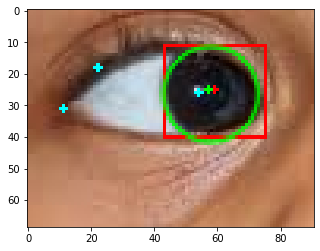

(42, 22)
(46, 22)
[<KeyPoint 0x122b005a0>]


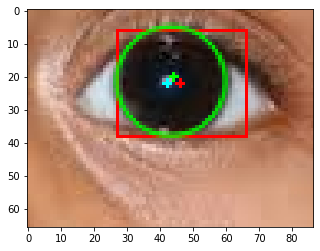

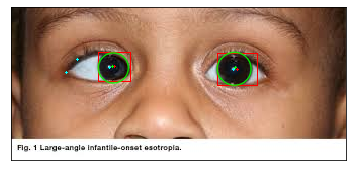

(<matplotlib.image.AxesImage at 0x124cf1a20>, None)

In [292]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
ye = detect_eyes(img, EYE_CLASSIFIER)

threshold = 60
for e in ye:
    if e is not None:
        e = cut_eyebrows(e)
        find_center(e)
        kp = blob_process(e, threshold, detector)
        e = cv2.drawKeypoints(e, kp, e, (0,255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.imshow(e)
        plt.show()
        
plt.xticks([]),plt.yticks([])
plt.imshow(img),plt.show()

### Isolate eye using bounding box

[[[74 40]
  [ 5 37]
  [ 6  5]
  [75  8]]]


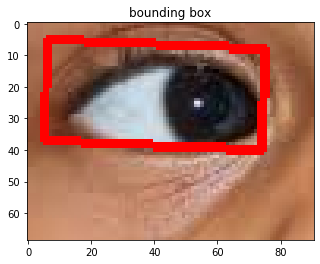

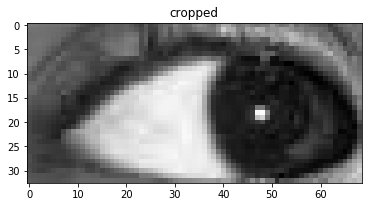

[[[90 68]
  [ 0 68]
  [ 0  0]
  [90  0]]]
[[[32 42]
  [22  9]
  [70 -4]
  [79 28]]]


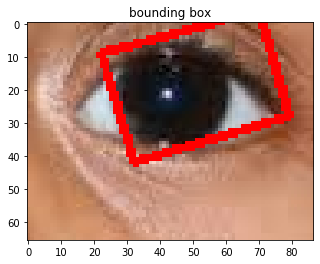

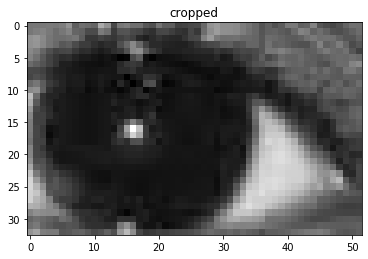

[[[86 65]
  [ 0 65]
  [ 0  0]
  [86  0]]]


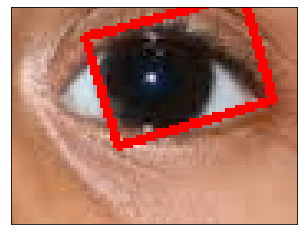

(<matplotlib.image.AxesImage at 0x12594b048>, None)

In [334]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
y = detect_eyes(img, EYE_CLASSIFIER)

for img in y:
    if img is not None:
        img = cut_eyebrows(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,60, 255,cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
#             print(area)
            if area < 200:
                continue
            
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            
            ext_left = tuple(contour[contour[:, :, 0].argmin()][0])
            ext_right = tuple(contour[contour[:, :, 0].argmax()][0])
            ext_top = tuple(contour[contour[:, :, 1].argmin()][0])
            ext_bot = tuple(contour[contour[:, :, 1].argmax()][0])
                    
            roi_corners = np.array([box], dtype=np.int32)
            print(roi_corners)
            # ignore if corners start with 0
            if 0 not in roi_corners.T:
                cv2.polylines(img, roi_corners, 1, (255, 0, 0), 2)
                plt.imshow(img), plt.title('bounding box')
                plt.show()

                cropped_image = gray[ext_top[1]:ext_bot[1], ext_left[0]:ext_right[0]]
                plt.imshow(cropped_image, cmap='gray')
                plt.title('cropped')
                plt.show()

In [370]:
def crop_image(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,60, 255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
#             print(area)
        if area < 200:
            continue

        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)

        ext_left = tuple(contour[contour[:, :, 0].argmin()][0])
        ext_right = tuple(contour[contour[:, :, 0].argmax()][0])
        ext_top = tuple(contour[contour[:, :, 1].argmin()][0])
        ext_bot = tuple(contour[contour[:, :, 1].argmax()][0])

        roi_corners = np.array([box], dtype=np.int32)
#             print(roi_corners)

        # ignore if corners start with 0
        if 0 not in roi_corners.T:
            cropped_img = img[ext_top[1]:ext_bot[1], ext_left[0]:ext_right[0]]
            
    return cropped_img

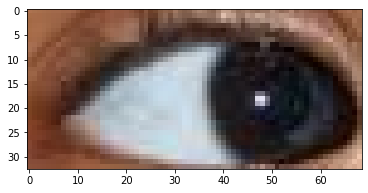

(<matplotlib.image.AxesImage at 0x126002ef0>, None)

In [372]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
x= crop_image(img)

plt.imshow(x),plt.show()

Nonzero:879              Zero:1398          Ratio:61.3965744400527


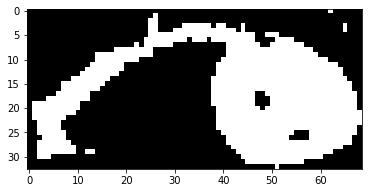

11.5
13.5


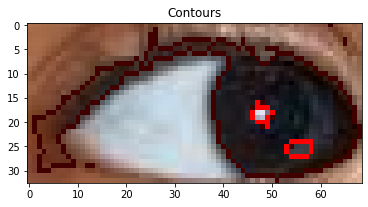

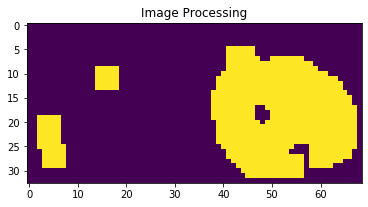

Nonzero:943              Zero:773          Ratio:45.04662004662005


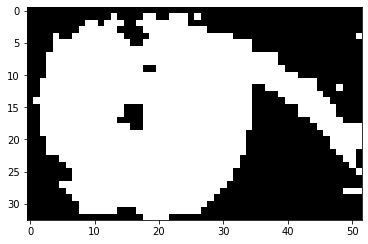

18.0
4.0


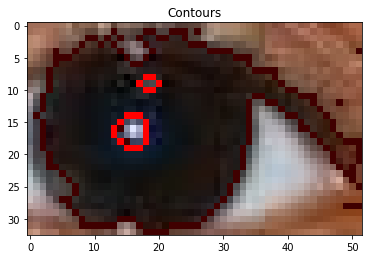

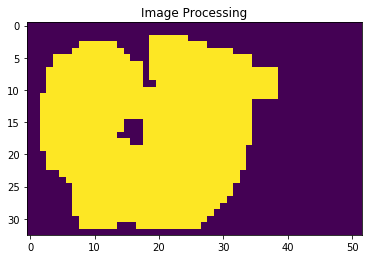

In [436]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
ex = detect_eyes(img, EYE_CLASSIFIER)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

for s in ex:
    s = cut_eyebrows(s)
    s = crop_image(s)
    
    gray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    
    # inverse to count get black
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    # calculate nonzeros aka white
    nonzero = cv2.countNonZero(thresh)
    total = thresh.shape[0] * thresh.shape[1]
    zero = total - nonzero
    ratio = zero * 100 / float(total)
    print('Nonzero:{} \
             Zero:{} \
         Ratio:{}'.format(nonzero, zero, ratio))
    
    plt.imshow(thresh, cmap='gray')
    plt.show()
     
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(s, contours,-1,(64,0,0),1)
    
    # draw smaller contours
    for contour in contours:
        area = cv2.contourArea(contour)
        m = cv2.moments(contour)

        if area < 20 and area != 0:
            print(area)
#             if m['m00'] != 0:
#                 center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
#                 cv2.circle(s, center, 1, (255, 0, 0), -1)
            
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(s, box=ellipse, color=(255, 0, 0))
    
    
    plt.imshow(s)
    plt.title('Contours')
    plt.show()
    
    t = cv2.erode(thresh, kernel, iterations=1)
    t = cv2.dilate(t, kernel, iterations=1)
#     t = cv2.medianBlur(t, 5)

    plt.imshow(t)
    plt.title('Image Processing')
    plt.show()
    
    ### if no white pixels inside (255,255,255), do not draw?


### test pixel count

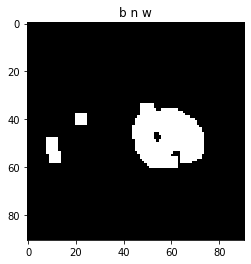

0 = 7588 pixels
255 = 693 pixels
Area of Largest Contour: 570.0


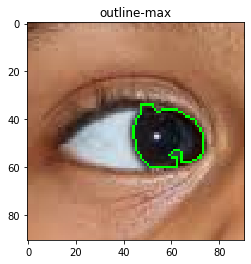

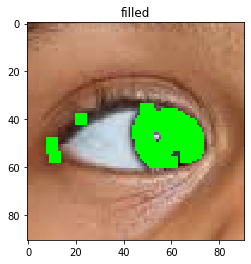

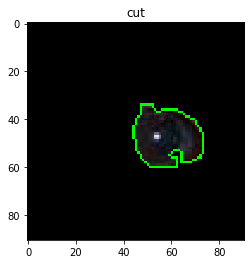

Nonzero:8172                  Zero:109              Ratio:1.3162661514309866


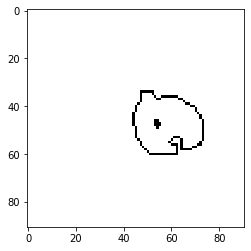

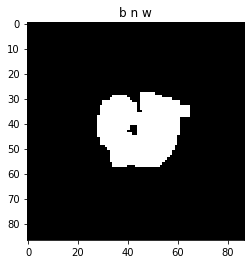

0 = 6738 pixels
255 = 831 pixels
Area of Largest Contour: 783.0


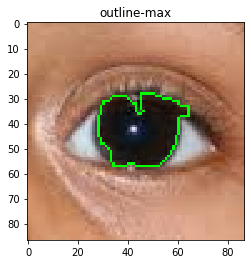

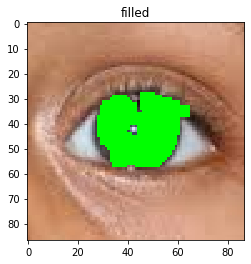

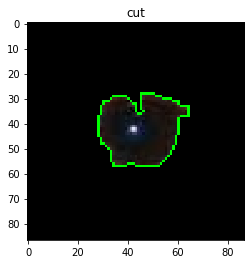

Nonzero:7439                  Zero:130              Ratio:1.7175320385784119


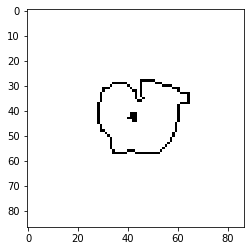

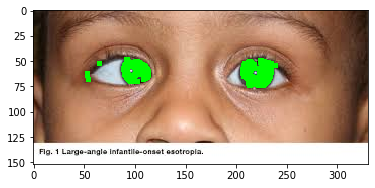

(<matplotlib.image.AxesImage at 0x125ade390>, None)

In [521]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
y = detect_eyes(img, EYE_CLASSIFIER)

for i in y:
    if i is not None:
        
        gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
        t = cv2.erode(thresh, kernel, iterations=1)
        t = cv2.dilate(t, kernel, iterations=1)
            
        colors, counts = np.unique(t.reshape(-1), axis=0, return_counts=True)
        plt.imshow(t,cmap='gray'),plt.title('b n w'),plt.show()
        for color, count in zip(colors, counts):
            print("{} = {} pixels".format(color, count))
            
        contours, hierarchy = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        ii = i.copy()
        m = max(contours, key = cv2.contourArea)
        
        cv2.drawContours(ii, m,-1,(0,255,0),1)
        cv2.drawContours(i, contours,-1,(0,255,0),cv2.FILLED)

        print("Area of Largest Contour:",cv2.contourArea(m))
#       
        plt.imshow(ii),plt.title('outline-max'),plt.show()
        plt.imshow(i),plt.title('filled'),plt.show()
        
        mask = np.zeros(ii.shape[:2],np.uint8)
        cv2.drawContours(mask,[m],-1,255,-1)
        dst = cv2.bitwise_and(ii,ii,mask=mask)
        
        plt.imshow(dst)
        plt.title('cut')
        plt.show()
        
        g = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        _,thresh2 = cv2.threshold(g,60,255, cv2.THRESH_BINARY_INV)

        nonzero = cv2.countNonZero(thresh2)
        total = thresh2.shape[0] * thresh2.shape[1]
        zero = total - nonzero
        ratio = zero * 100 / float(total)
        print('Nonzero:{} \
                 Zero:{} \
             Ratio:{}'.format(nonzero, zero, ratio))
    
        plt.imshow(thresh2,cmap='gray'),plt.show()
        


plt.imshow(img),plt.show()

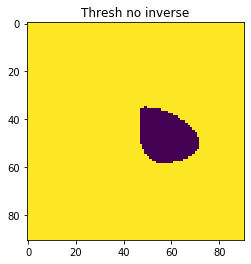

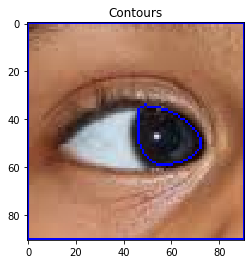

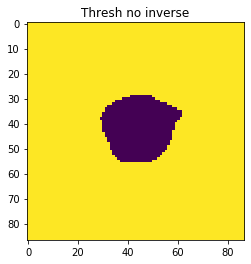

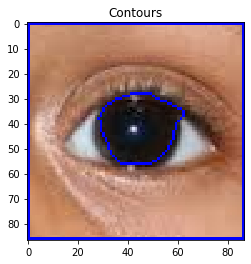

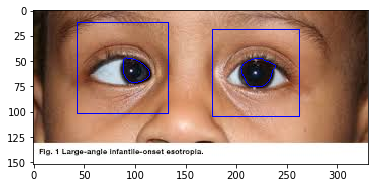

In [520]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
d = detect_eyes(img, EYE_CLASSIFIER)
for x in d:
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.medianBlur(thresh, 5)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(x, contours,-1,(0,0,255),1)
    
    plt.title('Thresh no inverse')
    plt.imshow(thresh),plt.show()
    
    plt.title('Contours')
    plt.imshow(x),plt.show()
    
plt.imshow(img)
plt.show()